# Plotting

> Utilities for plotting various things


In [ ]:
#| default_exp plotting

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#| export

from fastcore.basics import *
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.plot as rioplot
import matplotlib.patches as mpatches
from PIL import Image, ImageDraw

## Plotting object detection datasets

### COCO

In [ ]:
#| export

def plot_coco_instance(coco_data:dict, image_id:int, image_dir:Path, ax:plt.Axes,
                       plot_bbox:bool=True, plot_segmentation:bool=True,
                       show_labels:bool=True, show_title:bool=True) -> plt.Axes:
    ax.axis('off')
    anns_in_image = [a for a in coco_data['annotations'] if a['image_id'] == image_id]
    categories = [c['name'] for c in coco_data['categories']]
    image_fname = [i['file_name'] for i in coco_data['images'] if i['id'] == image_id][0]
    im = Image.open(image_dir/image_fname)
    ax.imshow(im)
    cmap = plt.get_cmap('tab20')
    for ann in anns_in_image:
        if 'segmentation' in ann.keys() and plot_segmentation:
            x_coords = [ann['segmentation'][0][i] for i in range(0, len(ann['segmentation'][0]), 2)]
            y_coords = [ann['segmentation'][0][i] for i in range(1, len(ann['segmentation'][0]), 2)]
            x_coords.append(x_coords[-1])
            y_coords.append(y_coords[-1])
            coords = np.array(list(zip(x_coords, y_coords)))
            ax.add_patch(mpatches.Polygon(coords, fill=False, linewidth=1.2, 
                                          edgecolor=np.array(cmap(ann['category_id']-1))))
        if plot_bbox:
            bbox = ann['bbox']
            if len(bbox) == 4:
                ax.add_patch(mpatches.Rectangle((bbox[0], bbox[1]),bbox[2], bbox[3], fill=False, linestyle='--',
                                                linewidth=2, edgecolor=np.array(cmap(ann['category_id']-1))))
            elif len(bbox) == 5:
                xc, yc, w, h, angle = bbox
                x = xc - w/2
                y = yc - h/2
                ax.add_patch(mpatches.Rectangle((x, y),w, h, angle=-angle, rotation_point='center', fill=False,
                             linestyle='--', linewidth=2, edgecolor=np.array(cmap(ann['category_id']-1))))
    if show_labels:
        ax.legend(handles=[mpatches.Patch(color=cmap(i), label=categories[i]) for i in range_of(categories)])
    if show_title:
        ax.set_title(image_fname)
    return ax

In [ ]:
import json

In [ ]:
with open('example_data/tiles/coco_norm.json') as f:
    coco_data = json.load(f)

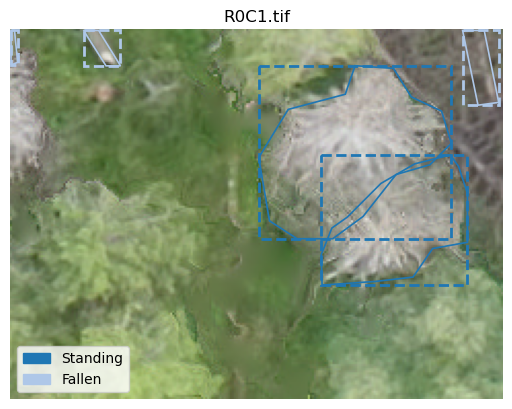

In [ ]:
fig, ax = plt.subplots(1,1)
plot_coco_instance(coco_data, 1, Path('example_data/tiles/images/'), ax, plot_bbox=True)
plt.show()

Also works with oriented bounding boxes

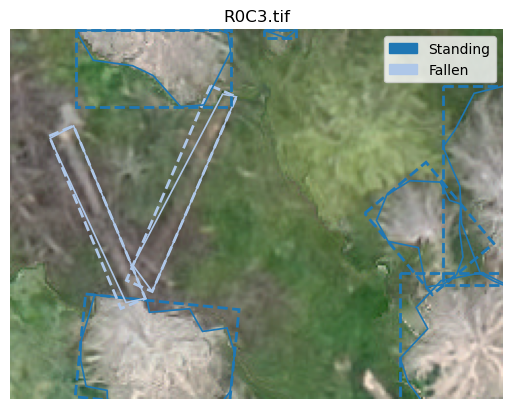

In [ ]:
with open('example_data/tiles/coco_rot.json') as f:
    coco_rot_data = json.load(f)
fig, ax = plt.subplots(1,1)
plot_coco_instance(coco_rot_data, 3, Path('example_data/tiles/images/'), ax, plot_bbox=True)
plt.show()

### YOLO

In [ ]:
#| export

def plot_yolo_instance(annotation_fname:Path, image_fname:Path, ax:plt.Axes,
                       ann_type:str='box', show_title:bool=True, classes:list[str]=None) -> plt.Axes:
    "Plot yolo format instance to `ax` and return it. If `classes` are provided show them in legend"
    image = Image.open(image_fname)
    w, h = image.size
    plotted_image = ImageDraw.Draw(image)
    cmap = plt.get_cmap('tab20')
    with open(annotation_fname) as f:
        anns = f.read().split("\n")[:-1]
        anns = [x.split(" ") for x in anns]
        anns = [[float(y) for y in x ] for x in anns]
    if ann_type == 'box':
        annotations = np.array(anns)
        transformed_annotations = np.copy(annotations)
        transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
        transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
        
        transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
        transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
        transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
        transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

        for ann in transformed_annotations:
            obj_cls, x0, y0, x1, y1 = ann
            c = tuple((np.array(cmap(obj_cls))*255).astype(np.uint8))
            plotted_image.rectangle(((x0,y0), (x1,y1)), outline=c)
            
    elif ann_type == 'polygon' or ann_type == 'rotated box':
        w, h = image.size
        plotted_image = ImageDraw.Draw(image)
            
        for ann in anns:
            obj_cls = ann[0]
            xcoords = [ann[i]*w for i in range(1, len(ann), 2)]
            ycoords = [ann[i]*h for i in range(2, len(ann)+1, 2)]
            xcoords.append(xcoords[0])
            ycoords.append(ycoords[0])
            c = tuple((np.array(cmap(obj_cls))*255).astype(np.uint8))
            plotted_image.polygon(list(zip(xcoords, ycoords)), outline=c)
            
    if classes:
        ax.legend(handles=[mpatches.Patch(color=cmap(i), label=classes[i]) for i in range_of(classes)])
    ax.imshow(np.array(image))
    return ax

<Axes: >

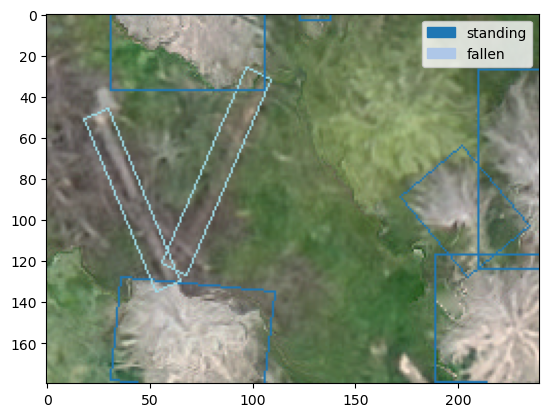

In [ ]:
fig, ax = plt.subplots(1,1)
classes = ['standing', 'fallen']
plot_yolo_instance(Path('example_data/tiles/labels/R0C3.txt'), Path('example_data/tiles/images/R0C3.tif'), ax, ann_type='polygon',
                   classes=classes)